# Installation

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
import numpy as np
import os
import sklearn
import tensorflow as tf

plt.rcParams['text.usetex'] = False
plt.rcParams["font.family"] = "serif"

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# Regression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, mean_squared_error, mean_absolute_error, r2_score

# **Read Data**

In [2]:
# Read a text file and transform it into a pandas dataframe
def read_txt_to_dataframe(file_path):
    try:
        # Read the contents of the file
        with open(file_path, 'r') as file:
            data = file.read()

        # Remove "<" and ">" symbols using string replace
        data = data.replace('<', '').replace('>', '')

        # Use StringIO to read the modified data into a DataFrame without changing the original file
        modified_file = StringIO(data)

        # Read the CSV data into a DataFrame
        df = pd.read_csv(modified_file)
        return df
    
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        return None

# Convert some columns into datetime objects
def convert_to_time_series(df):
    # Convert the 'DTYYYYMMDD' column to a datetime object
    df['DTYYYYMMDD'] = pd.to_datetime(df['DTYYYYMMDD'], format='%Y%m%d')
    
    # Create a weekly time lag column
    df['WEEK'] = df['DTYYYYMMDD'].dt.isocalendar().week
    
    # Convert the 'TIME' column to a datetime object
    df['TIME'] = pd.to_datetime(df['TIME'].astype(str).str.zfill(6), format='%H%M%S').dt.time

    # Combining the 'DTYYYYMMDD' and 'TIME' columns into a single 'DATE' column
    df['DATE'] = pd.to_datetime(df['DTYYYYMMDD'].astype(str) + ' ' + df['TIME'].astype(str))

    # Drop the 'DTYYYYMMDD' and 'TIME' columns
    df.drop(columns=['DTYYYYMMDD', 'TIME'], inplace=True)

    return df

In [3]:
# Initialize empty dataframes
bp_dia_df = pd.DataFrame()
bp_min_df = pd.DataFrame()

# Loop through the files in the "Data" folder
for file_name in ["bp1dia.txt", "bp1min.txt"]:
  file_path = os.path.join('datos', file_name)
  
  # Check if the file name ends with "dia.txt"
  if file_name.endswith('dia.txt'):
    temp_df = read_txt_to_dataframe(file_path)
    temp_df = convert_to_time_series(temp_df)
    bp_dia_df = pd.concat([bp_dia_df, temp_df], ignore_index=True)
  
  # Check if the file name ends with "min.txt"
  elif file_name.endswith('min.txt'):
    temp_df = read_txt_to_dataframe(file_path)
    temp_df = convert_to_time_series(temp_df)
    bp_min_df = pd.concat([bp_min_df, temp_df], ignore_index=True)

bp_dia_df.drop(['TICKER', 'PER', 'OPENINT', 'WEEK'], axis=1, inplace=True)
bp_min_df.drop(['TICKER', 'PER', 'OPENINT', 'WEEK'], axis=1, inplace=True)

# **Regression**
Predict the open/close value of a future

## Feature selection
In this step, we will identify, create and select the most relevant features that contribute to the accuracy of the regression models. Feature selection helps reduce dimensionality, removes irrelevant or redundant data, and enhances the model’s performance and interpretability.

In [4]:
bp_dia_df_regression = bp_dia_df.copy()

# Define change, evolution and bullish features
bp_dia_df_regression['CHANGE'] = bp_dia_df_regression['CLOSE'] - bp_dia_df_regression['OPEN']
bp_dia_df_regression['EVOLUTION'] = bp_dia_df_regression['OPEN'] - bp_dia_df_regression['CLOSE'].shift(1)
bp_dia_df_regression['BULLISH'] = (bp_dia_df_regression['CLOSE'] > bp_dia_df_regression['OPEN']).astype(int)

# Create lag features (for the last 4 candlesticks)
lag_features = ['BULLISH', 'CHANGE', 'EVOLUTION']
num_lags = 4

for lag in range(1, num_lags + 1):
    for feature in lag_features:
        bp_dia_df_regression[f'{feature}_lag{lag}'] = bp_dia_df_regression[feature].shift(lag)

# Drop rows with NaNs resulting from lagging
bp_dia_df_regression = bp_dia_df_regression.dropna()

# Extract features
# Year, month, day
bp_dia_df_regression['year'] = bp_dia_df_regression['DATE'].dt.year
bp_dia_df_regression['month'] = bp_dia_df_regression['DATE'].dt.month
bp_dia_df_regression['day'] = bp_dia_df_regression['DATE'].dt.day

# Cyclical encoding for month, day, hour, minute, second
bp_dia_df_regression['month_sin'] = np.sin(2 * np.pi * bp_dia_df_regression['month'] / 12)
bp_dia_df_regression['month_cos'] = np.cos(2 * np.pi * bp_dia_df_regression['month'] / 12)

bp_dia_df_regression['day_sin'] = np.sin(2 * np.pi * bp_dia_df_regression['day'] / 31)  # 31 days in most months
bp_dia_df_regression['day_cos'] = np.cos(2 * np.pi * bp_dia_df_regression['day'] / 31)

# Convert 'DATE' to numeric
bp_dia_df_regression['ordinal_date'] = bp_dia_df_regression['DATE'].map(lambda x: x.toordinal())

# Drop original datetime columns
bp_dia_df_regression.drop(columns=['DATE', 'year', 'month', 'day'], inplace=True)

## Models and evaluation

In [5]:
# Split into training and testing
X = bp_dia_df_regression.drop(columns=['CLOSE', 'LOW', 'HIGH'])  # Features
y = bp_dia_df_regression['CLOSE']                 # Target variable

# Divide datasets into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=False)

### KNN

Mean Squared Error: 0.01
Mean Absolute Error: 0.08
Root Mean Squared Error: 0.10
R^2: -1.29


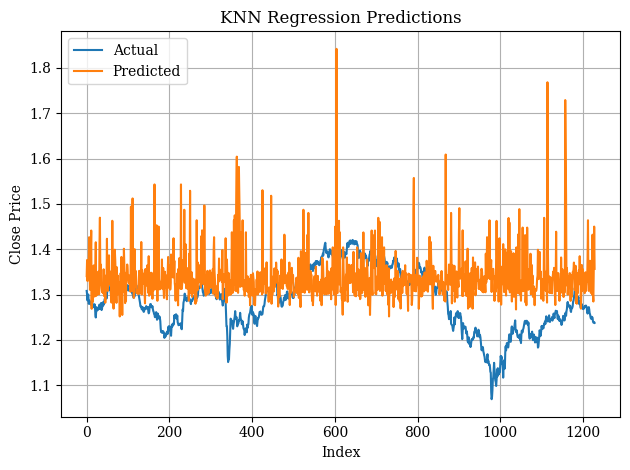

In [6]:
# Initialize the model
knn = KNeighborsRegressor(n_neighbors=5, metric='manhattan')

# Train the model
knn.fit(X_train, y_train)

# Make predictions
y_pred = knn.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'R^2: {r2:.2f}')

# Plot the predictions
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('KNN Regression Predictions')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

#### Grid search

Best parameters: {'n_neighbors': 13}
Mean Squared Error: 0.01
Mean Absolute Error: 0.08
Root Mean Squared Error: 0.11
R^2: -1.62


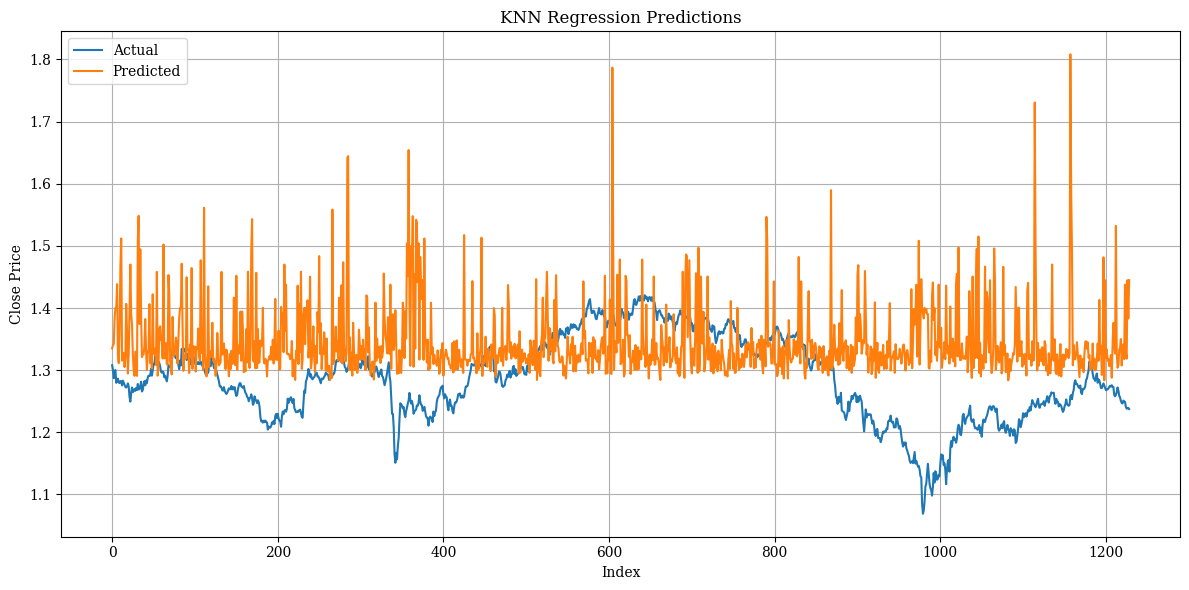

In [7]:
# Experiment with different values of k
param_grid = {'n_neighbors': range(1, 20)}
grid = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='r2')
grid.fit(X_train, y_train)

print(f"Best parameters: {grid.best_params_}")
knn = grid.best_estimator_

# Apply KNN regression for k = grid.best_estimator_
knn = KNeighborsRegressor(n_neighbors=grid.best_estimator_.n_neighbors)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'R^2: {r2:.2f}')

# Plot the predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('KNN Regression Predictions')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### Random Forest

Mean Squared Error: 0.00
Mean Absolute Error: 0.00
Root Mean Squared Error: 0.00
R^2: 1.00


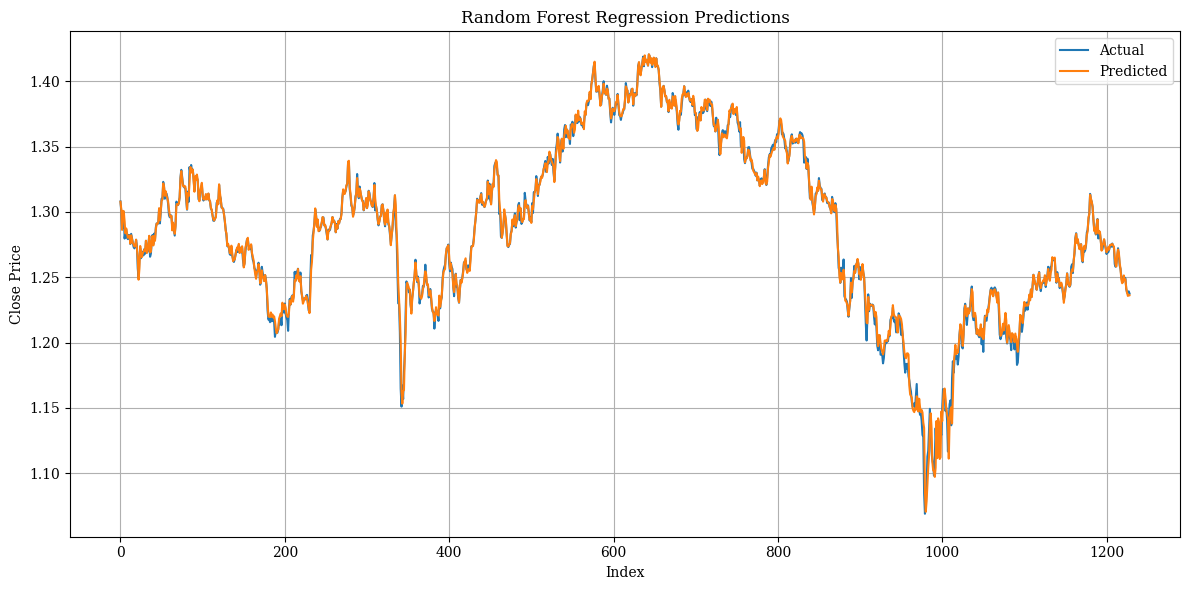

In [8]:
# Initialize the model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'R^2: {r2:.2f}')

# Plot the predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Random Forest Regression Predictions')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### SVM

Mean Squared Error: 0.05
Mean Absolute Error: 0.22
Root Mean Squared Error: 0.23
R^2: -10.79


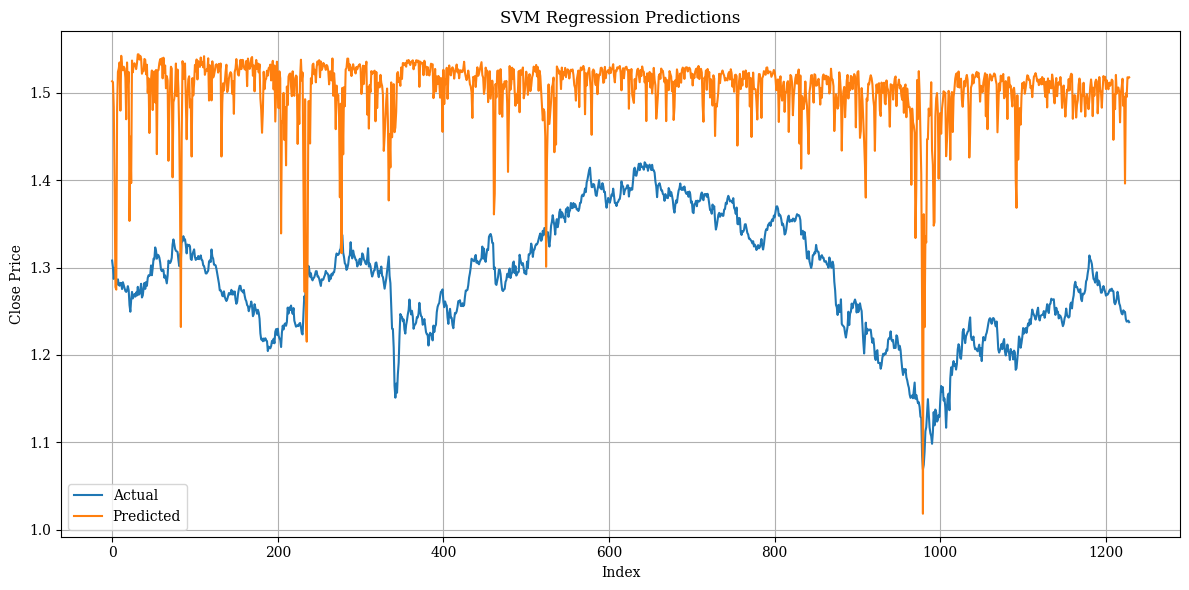

In [9]:
# Initialize the model
svr = SVR()

# Train the model
svr.fit(X_train, y_train)

# Make predictions
y_pred = svr.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'R^2: {r2:.2f}')

# Plot the predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('SVM Regression Predictions')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### LSTM

In [10]:
# Assuming X and y are your feature and target DataFrames
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for LSTM (samples, timesteps, features)
timesteps = 10 # Number of timesteps to look back

def reshape_for_lstm(data, timesteps):
    sequences = []
    for i in range(len(data) - timesteps):
        sequences.append(data[i:i+timesteps])
    return np.array(sequences)

X_train_seq = reshape_for_lstm(X_train_scaled, timesteps)
X_test_seq = reshape_for_lstm(X_test_scaled, timesteps)

# Ensure the target values are aligned correctly with the sequences
y_train_seq = y_train[timesteps:].values  # Align target with sequences
y_test_seq = y_test[timesteps:].values

# Confirm the shapes of the data
print(f'X_train_seq shape: {X_train_seq.shape}')
print(f'X_test_seq shape: {X_test_seq.shape}')
print(f'y_train_seq shape: {y_train_seq.shape}')
print(f'y_test_seq shape: {y_test_seq.shape}')

# Define LSTM model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.1),
    LSTM(64),
    Dropout(0.1),
    Dense(1)  # Output layer for regression
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Summary of the model
model.summary()

history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=50, 
    batch_size=32
)

X_train_seq shape: (11048, 10, 22)
X_test_seq shape: (1219, 10, 22)
y_train_seq shape: (11048,)
y_test_seq shape: (1219,)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 128)        │        77,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 126,785 (495.25 KB)

 Trainable params: 126,785 (495.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.3258 - mae: 0.3288 - val_loss: 0.0091 - val_mae: 0.0864
Epoch 2/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0090 - mae: 0.0745 - val_loss: 0.0019 - val_mae: 0.0356
Epoch 3/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0069 - mae: 0.0658 - val_loss: 0.0032 - val_mae: 0.0516
Epoch 4/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0058 - mae: 0.0601 - val_loss: 6.0866e-04 - val_mae: 0.0193
Epoch 5/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0057 - mae: 0.0593 - val_loss: 3.5043e-04 - val_mae: 0.0142
Epoch 6/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0058 - mae: 0.0601 - val_loss: 3.8560e-04 - val_mae: 0.0147
Epoch 7/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0055 - mae: 0.0583 - val_loss: 6.3843e-04 - val_mae: 0.0195
Epoch 8/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0052 - mae: 0.0576 - val_loss: 0.0016 - val_mae: 0.0353
Epoch 9/50
346/346 ━━━━━━━━━━━━

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step


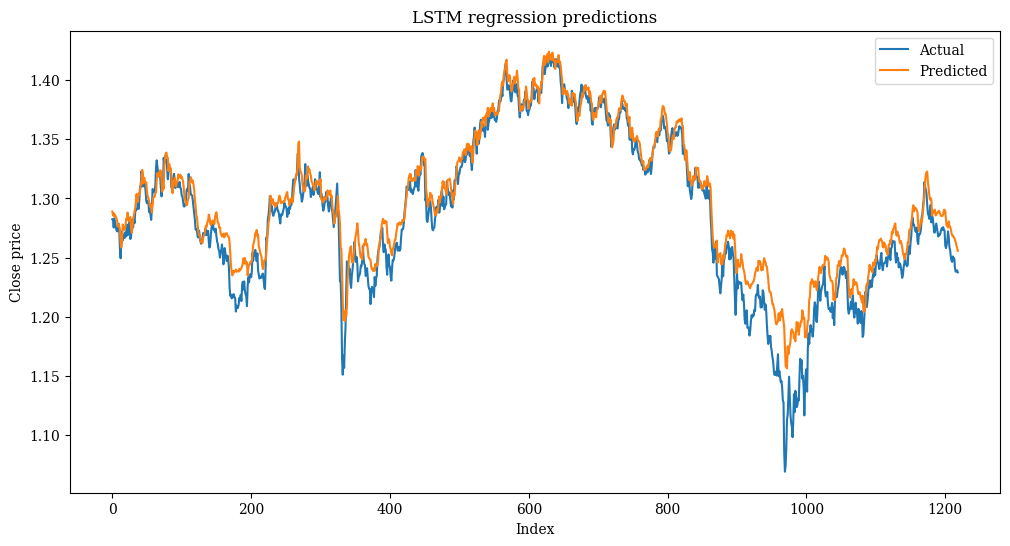

In [11]:
# Predictions
y_pred = model.predict(X_test_seq)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(y_test_seq, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title('LSTM regression predictions')
plt.xlabel('Index')
plt.ylabel('Close price')
plt.savefig('lstm_regression.png')
plt.show()

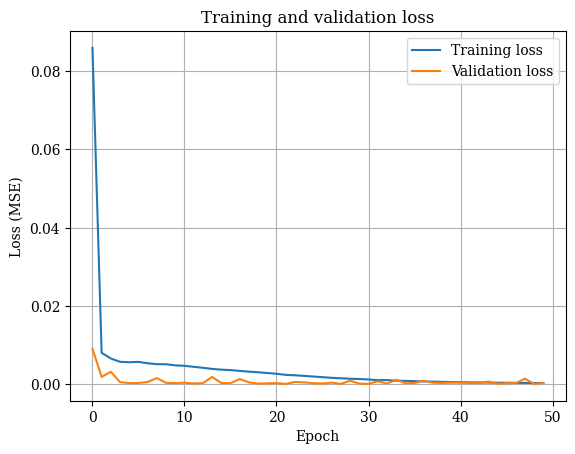

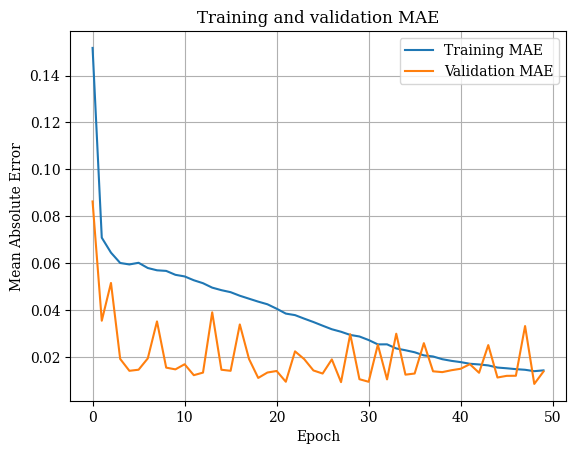

Mean Squared Error: 0.0003767672801453117
Root Mean Squared Error: 0.01941049407267398
Mean Absolute Error: 0.013902805023881819
R^2: 0.914328248020188


In [12]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid()
plt.savefig('lstm_loss.png')
plt.show()

# Plot the training and validation MAE
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid()
plt.savefig('lstm_mae.png')
plt.show()

# Evaluation metrics
mse = mean_squared_error(y_test_seq, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_seq, y_pred)
r2 = r2_score(y_test_seq, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'R^2: {r2}')

#### Cross validation

Score for fold 1: loss of 0.007512538228183985; compile_metrics of 0.04882986843585968
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
Score for fold 2: loss of 0.00028976230532862246; compile_metrics of 0.012059461325407028
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
Score for fold 3: loss of 0.0001417809835402295; compile_metrics of 0.00949317030608654
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
Score for fold 4: loss of 0.0004644460277631879; compile_metrics of 0.016824541613459587
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Score for fold 5: loss of 0.00043534356518648565; compile_metrics of 0.015616385266184807
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


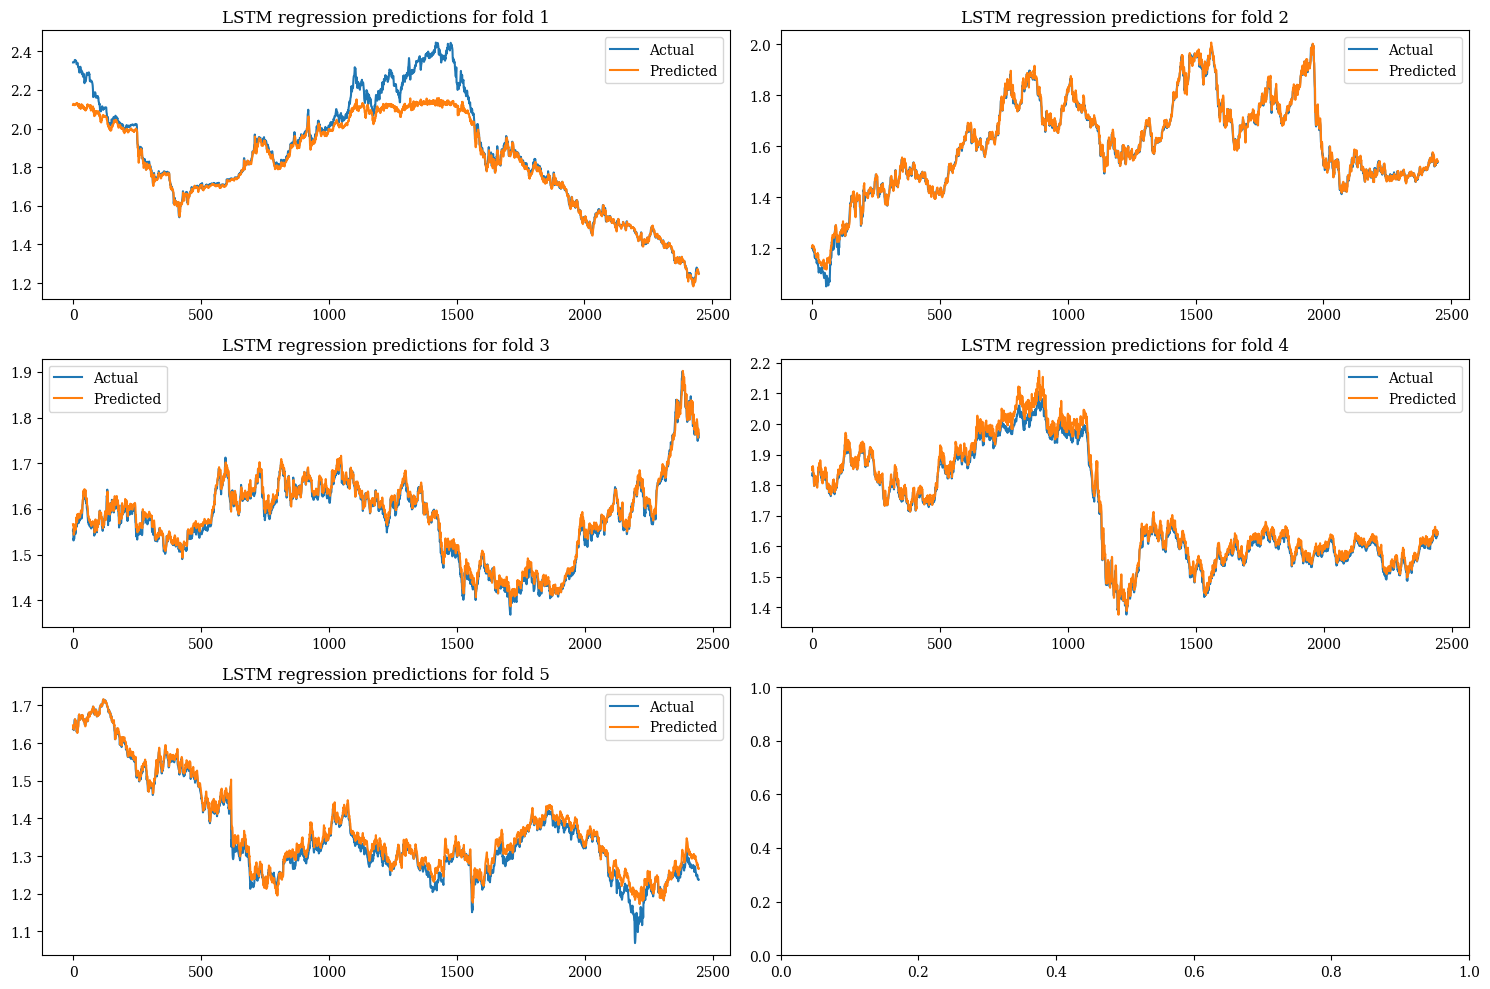

Mean Squared Error: 0.0004353435123897823
Root Mean Squared Error: 0.02086488706870426
Mean Absolute Error: 0.015616382536052143
R^2: 0.9756725760162175


In [13]:
# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=False)

# K-fold Cross Validation model evaluation
fold_no = 1

fig, axs = plt.subplots(3, 2, figsize=(15, 10))
axs = axs.flatten()

for train, test in kfold.split(X, y):
    # Split data
    X_train, X_test = X.iloc[train], X.iloc[test]
    y_train, y_test = y.iloc[train], y.iloc[test]
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Reshape for LSTM
    X_train_seq = reshape_for_lstm(X_train_scaled, timesteps)
    X_test_seq = reshape_for_lstm(X_test_scaled, timesteps)
    
    # Ensure the target values are aligned correctly with the sequences
    y_train_seq = y_train[timesteps:].values
    y_test_seq = y_test[timesteps:].values
    
    # Define the model
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
        Dropout(0.1),
        LSTM(64),
        Dropout(0.1),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    
    # Fit the model
    history = model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32, verbose=0)
    
    # Generate generalization metrics
    scores = model.evaluate(X_test_seq, y_test_seq, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]}')

    # Plot the predictions
    y_pred = model.predict(X_test_seq)
    axs[fold_no - 1].plot(y_test_seq, label='Actual')
    axs[fold_no - 1].plot(y_pred, label='Predicted')
    axs[fold_no - 1].legend()
    axs[fold_no - 1].set_title(f'LSTM regression predictions for fold {fold_no}')
    
    fold_no += 1

plt.tight_layout()
plt.show()

# Evaluation metrics
mse = mean_squared_error(y_test_seq, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_seq, y_pred)
r2 = r2_score(y_test_seq, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'R^2: {r2}')

#### Ablation studies

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 10, 128)        │        77,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 126,785 (495.25 KB)

 Trainable params: 126,785 (495.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.3734 - mae: 0.3304 - val_loss: 0.0206 - val_mae: 0.1287
Epoch 2/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 8.5912e-04 - mae: 0.0228 - val_loss: 0.0065 - val_mae: 0.0671
Epoch 3/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 4.1762e-04 - mae: 0.0160 - val_loss: 0.0078 - val_mae: 0.0772
Epoch 4/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 3.0617e-04 - mae: 0.0136 - val_loss: 0.0055 - val_mae: 0.0638
Epoch 5/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 2.6255e-04 - mae: 0.0125 - val_loss: 0.0048 - val_mae: 0.0597
Epoch 6/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 2.5396e-04 - mae: 0.0125 - val_loss: 0.0033 - val_mae: 0.0481
Epoch 7/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 2.4616e-04 - mae: 0.0123 - val_loss: 0.0019 - val_mae: 0.0341
Epoch 8/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 2.1385e-04 - mae: 0.0115 - val_loss: 0.0030 - val_mae: 0.0451
Epoch 9/50
307/307 

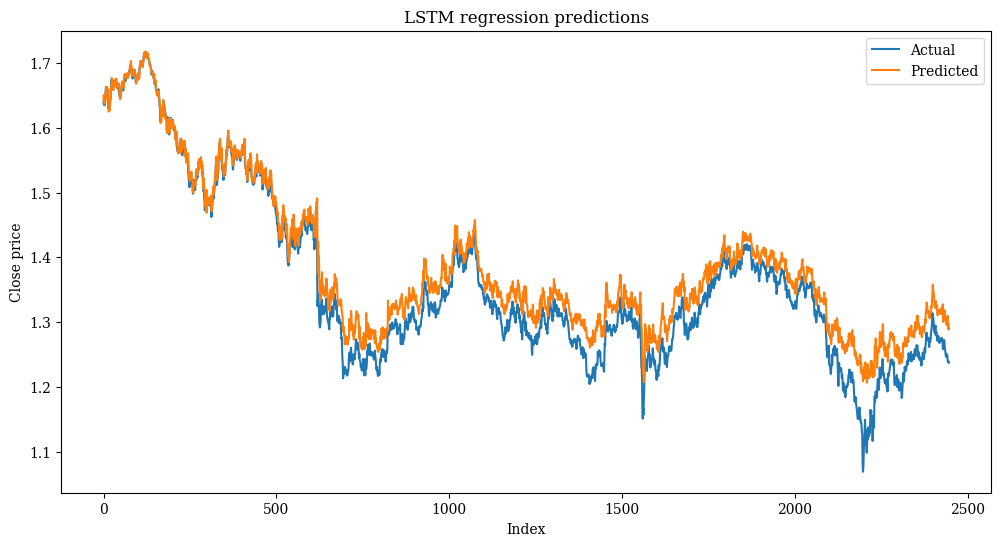

Mean Squared Error: 0.0012229515202387734
Root Mean Squared Error: 0.03497072375914993
Mean Absolute Error: 0.02894948970590458
R^2: 0.9316602652899477


In [14]:
# Ablation studies: removing the dropout layers
# Define LSTM model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    LSTM(64),
    Dense(1)  # Output layer for regression
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Summary of the model
model.summary()

history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=50,  # You can increase this if needed
    batch_size=32
)

# Predictions
y_pred = model.predict(X_test_seq)

plt.figure(figsize=(12, 6))
plt.plot(y_test_seq, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title('LSTM regression predictions')
plt.xlabel('Index')
plt.ylabel('Close price')
plt.savefig('lstm_regression.png')
plt.show()

# Give the MSE, RMSE, MAE and R squared values
mse = mean_squared_error(y_test_seq, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_seq, y_pred)
r2 = r2_score(y_test_seq, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'R^2: {r2}')


##### Cross validation for ablation studies

Score for fold 1: loss of 0.0023780958727002144; compile_metrics of 0.03265852853655815
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Score for fold 2: loss of 0.0005235479911789298; compile_metrics of 0.01793753355741501
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Score for fold 3: loss of 0.00023365642118733376; compile_metrics of 0.012263217009603977
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Score for fold 4: loss of 0.0004245552991051227; compile_metrics of 0.017242245376110077
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Score for fold 5: loss of 0.0008685360080562532; compile_metrics of 0.02190420962870121
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


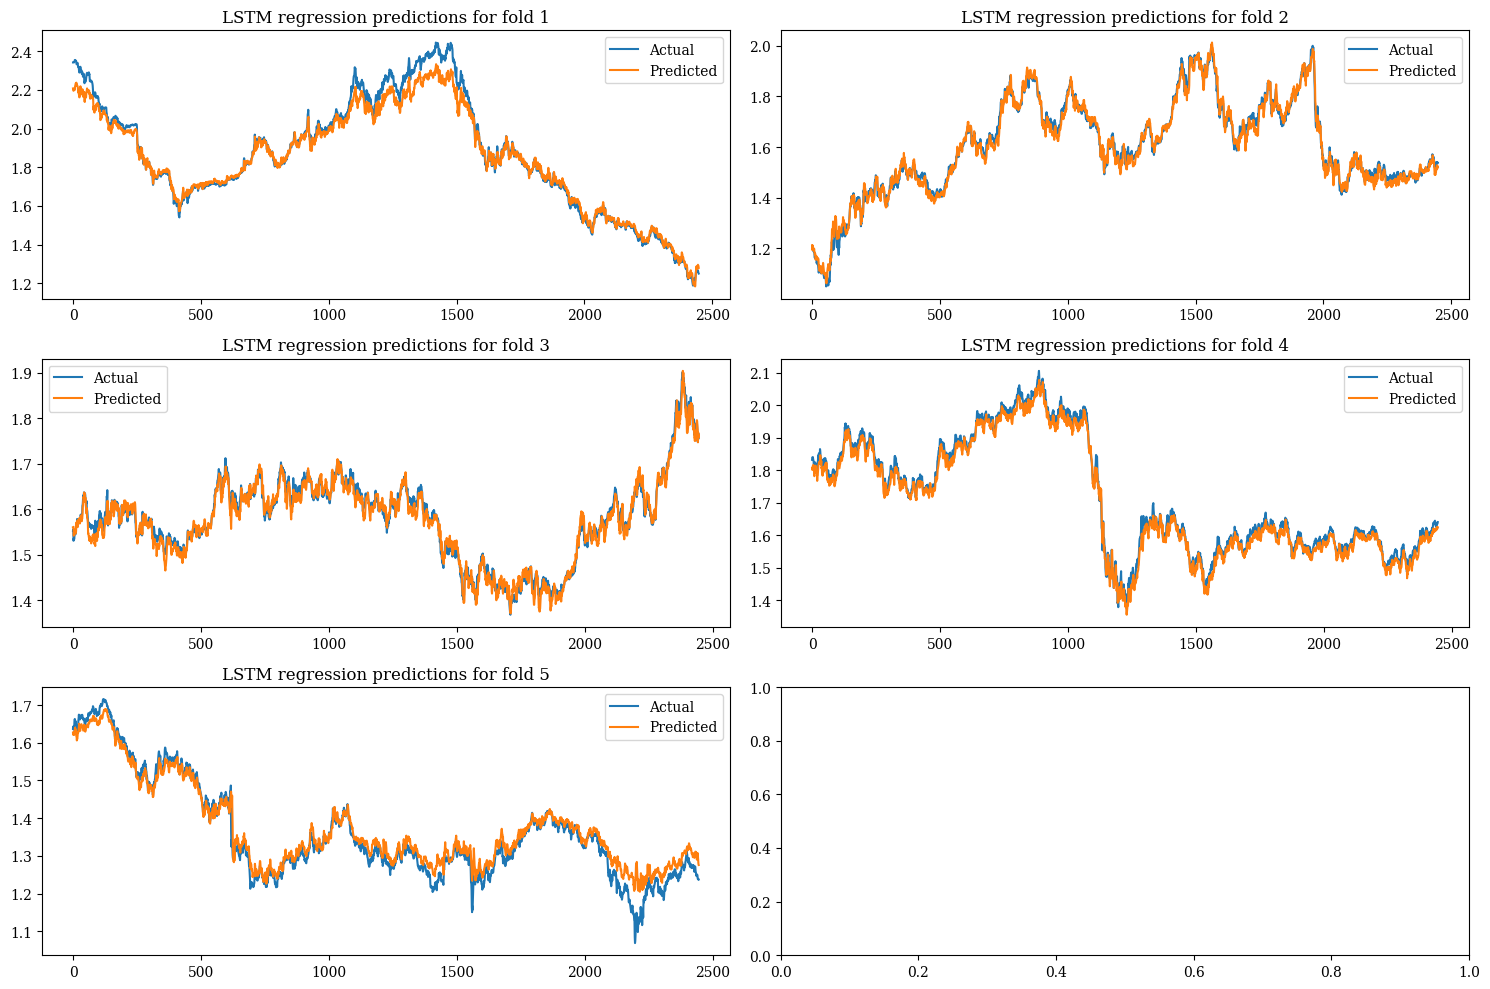

Mean Squared Error: 0.0008685359960702074
Root Mean Squared Error: 0.029470934767499443
Mean Absolute Error: 0.021904210147849868
R^2: 0.9514653536339853


In [15]:
# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=False)

# K-fold Cross Validation model evaluation
fold_no = 1

fig, axs = plt.subplots(3, 2, figsize=(15, 10))
axs = axs.flatten()

for train, test in kfold.split(X, y):
    # Split data
    X_train, X_test = X.iloc[train], X.iloc[test]
    y_train, y_test = y.iloc[train], y.iloc[test]
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Reshape for LSTM
    X_train_seq = reshape_for_lstm(X_train_scaled, timesteps)
    X_test_seq = reshape_for_lstm(X_test_scaled, timesteps)
    
    # Ensure the target values are aligned correctly with the sequences
    y_train_seq = y_train[timesteps:].values
    y_test_seq = y_test[timesteps:].values
    
    # Define the model
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
        LSTM(64),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    
    # Fit the model
    history = model.fit(X_train_seq, y_train_seq, epochs=12, batch_size=32, verbose=0)
    
    # Generate generalization metrics
    scores = model.evaluate(X_test_seq, y_test_seq, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]}')

    # Plot the predictions
    y_pred = model.predict(X_test_seq)
    axs[fold_no - 1].plot(y_test_seq, label='Actual')
    axs[fold_no - 1].plot(y_pred, label='Predicted')
    axs[fold_no - 1].legend()
    axs[fold_no - 1].set_title(f'LSTM regression predictions for fold {fold_no}')
    
    fold_no += 1

plt.tight_layout()
plt.show()

# Evaluation metrics
mse = mean_squared_error(y_test_seq, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_seq, y_pred)
r2 = r2_score(y_test_seq, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'R^2: {r2}')